**Определение перспективного тарифа для телеком-компании**

In [2]:
import seaborn as sns
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
from datetime import datetime

## **Описание проекта**

**Описание тарифов:**

**Тариф «Смарт»**
- Ежемесячная плата: 550 рублей
- Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета:
- минута разговора: 3 рубля
- сообщение: 3 рубля
- 1 Гб интернет-трафика: 200 рублей

**Тариф «Ультра»**
- Ежемесячная плата: 1950 рублей
- Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета:
- минута разговора: 1 рубль
- сообщение: 1 рубль
- 1 Гб интернет-трафика: 150 рублей

### Описание данных

**Таблица `users` (информация о пользователях):**

`user_id` — уникальный идентификатор пользователя

`first_name` — имя пользователя

`last_name` — фамилия пользователя

`age` — возраст пользователя (годы)

`reg_date` — дата подключения тарифа (день, месяц, год)

`churn_date` — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)

`city` — город проживания пользователя

`tarif` — название тарифного плана


**Таблица `calls` (информация о звонках):**
`id` — уникальный номер звонка

`call_date` — дата звонка

`duration` — длительность звонка в минутах

`user_id` — идентификатор пользователя, сделавшего звонок


**Таблица `messages` (информация о сообщениях):**
`id` — уникальный номер сообщения

`message_date` — дата сообщения

`user_id` — идентификатор пользователя, отправившего сообщение


**Таблица `internet` (информация об интернет-сессиях):**
`id` — уникальный номер сессии

`mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах)

`session_date` — дата интернет-сессии

`user_id` — идентификатор пользователя


**Таблица `tariffs` (информация о тарифах):**
`tariff_name` — название тарифа

`rub_monthly_fee` — ежемесячная абонентская плата в рублях

`minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату

`messages_included` — количество сообщений в месяц, включённых в абонентскую плату

`mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)

`rub_per_minute` — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)

`rub_per_message` — стоимость отправки сообщения сверх тарифного пакета

`rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

## **Предобработка данных**

- Приведите данные к нужным типам;

- Найдите и исправьте ошибки в данных, если они есть.

- Поясните, какие ошибки вы нашли и как их исправили. В данных вы найдёте звонки с нулевой продолжительностью. Это не ошибка: нулями обозначены пропущенные звонки, поэтому их не нужно удалять.



- При прочтении методом read_csv добавим индекс index_col=0 в датасет internet, также приведем столбцы к нужным типам.

In [3]:
custom_date_parser = lambda x: datetime.strptime(x, '%Y-%m-%d')
tariffs = pd.read_csv('D:/datasets/tariffs.csv')

users = pd.read_csv('D:/datasets/users.csv',
                   parse_dates=['reg_date'],
                   date_parser=custom_date_parser)

calls = pd.read_csv('D:/datasets/calls.csv',
                   parse_dates=['call_date'],
                   date_parser=custom_date_parser)

messages = pd.read_csv('D:/datasets/messages.csv',
                      parse_dates=['message_date'],
                      date_parser=custom_date_parser)

internet = pd.read_csv('D:/datasets/internet.csv',
                       index_col=0,
                      parse_dates=['session_date'],
                      date_parser=custom_date_parser)

In [4]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     object        
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 31.4+ KB


In [5]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  float64       
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


In [6]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


In [7]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            149396 non-null  object        
 1   mb_used       149396 non-null  float64       
 2   session_date  149396 non-null  datetime64[ns]
 3   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 5.7+ MB


- **Откроем первый проблемный датасет, видим пропуски в столбце churn_date, трогать не будем, т.к. в дальнейшем данный столбец нам не пригодится.**

In [8]:
users.head(10)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


- «Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.

- Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

In [9]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  float64       
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


In [10]:
def duration(call):
    if 0 < call < 1:
        return 1
    else:
        return call
calls['duration'] = calls['duration'].apply(duration)
calls['duration'] = calls['duration'].astype('int') 
calls = calls.query('duration >= 1')

- **Все звонки, которые длились 0 секунд считаются сброшенными/неотвеченным, их мы уберем, а звонки, которые длились хотя бы 1 секунду будут округлены до 1 минуты, согласно условию тарификации "Мегалайн".**

Есть 3 типа пропусков в данных:


- **Полностью случайные:** если вероятность встретить пропуск не
зависит ни от каких других значений. Ответ на этот вопрос не зависит
от характера самого вопроса и от других вопросов анкеты, а сам
пропуск легко восстановить по имени.

- **Случайные:** если вероятность пропуска зависит от других значений в
наборе данных, но не от значений собственного столбца.
Пропущенное значение связано с тем, что, например, такой категории
не существует.

- **Неслучайные:** если вероятность пропуска зависит от других
значений, в том числе и от значений собственного столбца.
Отсутствующее значение зависит как от характера вопроса, так и от
значения переменной в другом столбце.


### **Посчитаем для каждого пользователя:**
- количество сделанных звонков и израсходованных минут разговора по месяцам;

- количество отправленных сообщений по месяцам;

- объем израсходованного интернет-трафика по месяцам;

- помесячную выручку с каждого пользователя.

**Создадим в 3 датах сетах новый столбец с месяцем пользования**

In [11]:
calls['month'] = pd.to_datetime(calls['call_date']).dt.month
messages['month'] = pd.to_datetime(messages['message_date']).dt.month
internet['month'] = pd.to_datetime(internet['session_date']).dt.month

**Воспользуемся прелестью сводных таблиц и вычислим нужные параметры:**

- Группируем даныые **сalls** по  `user_id` и `month`.

In [12]:
calls_p = calls.pivot_table(index=['user_id', 'month'], aggfunc={'call_date':'count', 'duration':sum}) 
calls_p.columns = ['calls_count', 'calls_duration']
calls_p.head()

calls_count  calls_duration
user_id month                             
1000    5               17             143
        6               28             145
        7               41             301
        8               42             368
        9               46             424

- Группируем даныые **messages** по  `user_id` и `month`.

In [13]:
messages_p = messages.pivot_table(index=['user_id', 'month'], aggfunc={'id':'count'})
messages_p.columns = ['messages_count']
messages_p.head()

messages_count
user_id month                
1000    5                  22
        6                  60
        7                  75
        8                  81
        9                  57

- Группируем даныые **internet** по  `user_id` и `month`.

In [14]:
internet_p = internet.pivot_table(index=['user_id', 'month'], aggfunc={'mb_used':sum})
internet_p.columns = ['mb_used']
internet_p.head()

mb_used
user_id month          
1000    5       2253.49
        6      23233.77
        7      14003.64
        8      14055.93
        9      14568.91

**- Соединим 3 датасет в единный методом `join` с сортировкой по`month`**

In [15]:
df = internet_p.join([calls_p, messages_p]).reset_index(level='month')

In [16]:
df = users.join(df, on='user_id')

In [17]:
df.head(10)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,mb_used,calls_count,calls_duration,messages_count
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5.0,2253.49,17.0,143.0,22.0
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6.0,23233.77,28.0,145.0,60.0
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7.0,14003.64,41.0,301.0,75.0
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8.0,14055.93,42.0,368.0,81.0
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9.0,14568.91,46.0,424.0,57.0
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,10.0,14702.49,44.0,310.0,73.0
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,11.0,14756.47,37.0,301.0,58.0
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,12.0,9817.61,38.0,296.0,70.0
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart,11.0,18429.34,45.0,386.0,NaN
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart,12.0,14036.66,47.0,371.0,NaN


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3206 entries, 0 to 499
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   user_id         3206 non-null   int64         
 1   age             3206 non-null   int64         
 2   churn_date      188 non-null    object        
 3   city            3206 non-null   object        
 4   first_name      3206 non-null   object        
 5   last_name       3206 non-null   object        
 6   reg_date        3206 non-null   datetime64[ns]
 7   tariff          3206 non-null   object        
 8   month           3203 non-null   float64       
 9   mb_used         3203 non-null   float64       
 10  calls_count     3157 non-null   float64       
 11  calls_duration  3157 non-null   float64       
 12  messages_count  2706 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(2), object(5)
memory usage: 350.7+ KB


In [19]:
df = df.drop(['churn_date', 'first_name', 'last_name', 'reg_date'], axis='columns')

In [20]:
df = df.fillna(0)

In [21]:
df.dropna(subset = ['month', 'mb_used',], inplace = True)
df.isnull().sum()

user_id           0
age               0
city              0
tariff            0
month             0
mb_used           0
calls_count       0
calls_duration    0
messages_count    0
dtype: int64


**К новому датасету добавим информацию о тарифах из** `tariffs`

- Для этого, сменим  название столбца `tariff_name` на `tariff`

In [22]:
tariffs.rename(columns={'tariff_name': 'tariff'}, inplace=True)
tariffs.columns

Index(['messages_included', 'mb_per_month_included', 'minutes_included',
       'rub_monthly_fee', 'rub_per_gb', 'rub_per_message', 'rub_per_minute',
       'tariff'],
      dtype='object')

In [23]:
df = df.merge(tariffs, on='tariff', how='inner')

In [24]:
df.head()

,user_id,age,city,tariff,month,mb_used,calls_count,calls_duration,messages_count,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,52,Краснодар,ultra,5.0,2253.49,17.0,143.0,22.0,1000,30720,3000,1950,150,1,1
1,1000,52,Краснодар,ultra,6.0,23233.77,28.0,145.0,60.0,1000,30720,3000,1950,150,1,1
2,1000,52,Краснодар,ultra,7.0,14003.64,41.0,301.0,75.0,1000,30720,3000,1950,150,1,1
3,1000,52,Краснодар,ultra,8.0,14055.93,42.0,368.0,81.0,1000,30720,3000,1950,150,1,1
4,1000,52,Краснодар,ultra,9.0,14568.91,46.0,424.0,57.0,1000,30720,3000,1950,150,1,1


In [25]:
df['gb_per_month_included'] = df['mb_per_month_included'] / 1024
df['gb_used'] = df['mb_used'] / 1024
df['gb_per_month_included'] = df['gb_per_month_included'].astype('int')
df.pop('mb_per_month_included')

0       30720
1       30720
2       30720
3       30720
4       30720
        ...  
3201    15360
3202    15360
3203    15360
3204    15360
3205    15360
Name: mb_per_month_included, Length: 3206, dtype: int64

**Считаем помесячную выручку с каждого пользователя:**

- вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножим на значение из тарифного плана; прибавим абонентскую плату, соответствующую тарифному плану. 

In [26]:
def revenue(row):
    sms = (row['messages_count'] - row['messages_included']) * row['rub_per_message']
    mins = (row['calls_duration'] - row['minutes_included']) * row['rub_per_minute']
    gb = (row['gb_used'] - row['gb_per_month_included']) * row['rub_per_gb'] 
    total = 0
    for i in [sms, mins, gb]:
        if i > 0:
            total += i
    return total
df['tarif_ost'] = df.apply(revenue, axis = 1).astype('int')
df['full_paid'] = df['tarif_ost'] + df['rub_monthly_fee'].astype('int')

In [27]:
df = df[df['month'] != 0]
display(df.loc[df['month'] == 0])
df.head(10)

,user_id,age,city,tariff,month,mb_used,calls_count,calls_duration,messages_count,messages_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included,gb_used,tarif_ost,full_paid


,user_id,age,city,tariff,month,mb_used,calls_count,calls_duration,messages_count,messages_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included,gb_used,tarif_ost,full_paid
0,1000,52,Краснодар,ultra,5.0,2253.49,17.0,143.0,22.0,1000,3000,1950,150,1,1,30,2.200674,0,1950
1,1000,52,Краснодар,ultra,6.0,23233.77,28.0,145.0,60.0,1000,3000,1950,150,1,1,30,22.689229,0,1950
2,1000,52,Краснодар,ultra,7.0,14003.64,41.0,301.0,75.0,1000,3000,1950,150,1,1,30,13.675430,0,1950
3,1000,52,Краснодар,ultra,8.0,14055.93,42.0,368.0,81.0,1000,3000,1950,150,1,1,30,13.726494,0,1950
4,1000,52,Краснодар,ultra,9.0,14568.91,46.0,424.0,57.0,1000,3000,1950,150,1,1,30,14.227451,0,1950
5,1000,52,Краснодар,ultra,10.0,14702.49,44.0,310.0,73.0,1000,3000,1950,150,1,1,30,14.357900,0,1950
6,1000,52,Краснодар,ultra,11.0,14756.47,37.0,301.0,58.0,1000,3000,1950,150,1,1,30,14.410615,0,1950
7,1000,52,Краснодар,ultra,12.0,9817.61,38.0,296.0,70.0,1000,3000,1950,150,1,1,30,9.587510,0,1950
8,1003,23,Москва,ultra,8.0,8565.21,43.0,342.0,37.0,1000,3000,1950,150,1,1,30,8.364463,0,1950
9,1003,23,Москва,ultra,9.0,12468.87,105.0,862.0,91.0,1000,3000,1950,150,1,1,30,12.176631,0,1950


## **Проанализируем данные**

- Опишем поведение клиентов оператора, исходя из выборки. 

- Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? 

- Посчитаем среднее количество, дисперсию и стандартное отклонение. Построим гистограмму.

Сразу отметим, что большая часть пользователей пользуется тарифом `Smart`, в 2 раза меньше `Ultra`

In [28]:
df['tariff'].value_counts()

smart    2228
ultra     975
Name: tariff, dtype: int64

- **Вызовем панду  `describe()`  для просмотра некоторых основных статистических данных.**

### Посчитаем среднее количество, дисперсию и стандартное отклонение.

In [29]:
ultra = (df
      .query('tariff == "ultra"')
      .pivot_table(index='month', values=('calls_duration','messages_count','mb_used'), aggfunc=('mean', 'std', 'var'))    
)
ultra

calls_duration                                 mb_used                \
                mean         std           var          mean           std   
month                                                                        
1.0       383.888889  240.430055  57806.611111  13140.681111   6865.346875   
2.0       281.500000  270.849413  73359.404762  12846.477273  10473.403015   
3.0       438.432432  299.608591  89765.307808  17535.550270  10951.785885   
4.0       409.418182  240.441545  57812.136700  16828.134364   9718.649845   
5.0       459.939394  259.153764  67160.673193  19656.534091   9829.620332   
6.0       431.542169  272.213658  74100.275639  19152.950602   9109.904861   
7.0       490.922222  274.933832  75588.611860  20723.394778   9883.022284   
8.0       458.858491  280.527240  78695.532165  19760.734434  10349.849601   
9.0       484.815789  291.153840  84770.558687  19372.735702   9353.599420   
10.0      501.040984  292.387278  85490.320621  20209.643361   9671.980860   
11.0      486.120301  278.571628  77602.152085  19935.585489   9793.580544   
12.0      532.355072  306.489180  93935.617529  21951.094130  10247.207641   

                    messages_count                          
                var           mean        std          var  
month                                                       
1.0    4.713299e+07      33.777778  30.670742   940.694444  
2.0    1.096922e+08      23.727273  27.308087   745.731602  
3.0    1.199416e+08      32.297297  41.621886  1732.381381  
4.0    9.445215e+07      31.563636  37.513831  1407.287542  
5.0    9.662144e+07      38.106061  40.561114  1645.203963  
6.0    8.299037e+07      41.771084  44.836920  2010.349398  
7.0    9.767413e+07      49.988889  48.957329  2396.820100  
8.0    1.071194e+08      48.509434  46.817629  2191.890386  
9.0    8.748982e+07      52.464912  46.564292  2168.233271  
10.0   9.354721e+07      58.622951  52.104683  2714.897981  
11.0   9.591422e+07      55.992481  49.902252  2490.234792  
12.0   1.050053e+08      60.768116  51.943441  2698.121020

In [30]:
smart = (df
      .query('tariff == "smart"')
      .pivot_table(index='month', values=('calls_duration','messages_count','mb_used'), aggfunc=('mean', 'std', 'var'))    
)
smart

calls_duration                                 mb_used               \
                mean         std           var          mean          std   
month                                                                       
1.0       183.294118  139.470759  19452.092692   8513.717647  6444.681014   
2.0       267.896552  170.884971  29201.673321  11597.054310  6247.353833   
3.0       348.922078  172.655404  29809.888585  15104.159091  5828.237537   
4.0       328.160714  167.109855  27925.703668  13462.180625  5698.249092   
5.0       346.099291  167.677339  28115.690071  15805.184326  5978.231725   
6.0       353.914634  157.296110  24742.066288  15794.647988  5791.155586   
7.0       365.368159  161.244453  25999.773781  15743.150348  5897.154446   
8.0       378.555556  166.460112  27708.969003  16681.706068  5498.387304   
9.0       383.326923  164.507915  27062.854099  16303.578808  5196.115749   
10.0      381.340136  169.152535  28612.580158  16757.122891  5859.384492   
11.0      389.155063  159.711500  25507.763181  16895.696646  5340.273416   
12.0      428.038576  178.846190  31985.959817  18113.662047  5573.682673   

                    messages_count                         
                var           mean        std         var  
month                                                      
1.0    4.153391e+07      18.235294  16.197753  262.367201  
2.0    3.902943e+07      24.086207  21.750809  473.097701  
3.0    3.396835e+07      31.857143  26.804710  718.492481  
4.0    3.247004e+07      30.741071  24.538532  602.139559  
5.0    3.573925e+07      33.773050  27.036845  730.990983  
6.0    3.353748e+07      33.402439  28.404337  806.806374  
7.0    3.477643e+07      33.751244  28.282288  799.887811  
8.0    3.023226e+07      33.777778  28.935510  837.263710  
9.0    2.699962e+07      33.638462  28.117927  790.617820  
10.0   3.433239e+07      33.765306  28.567673  816.111966  
11.0   2.851852e+07      34.075949  28.389031  805.937071  
12.0   3.106594e+07      35.994065  30.576990  934.952346

### Построим гистограммы

(-1.0, 10000.0)

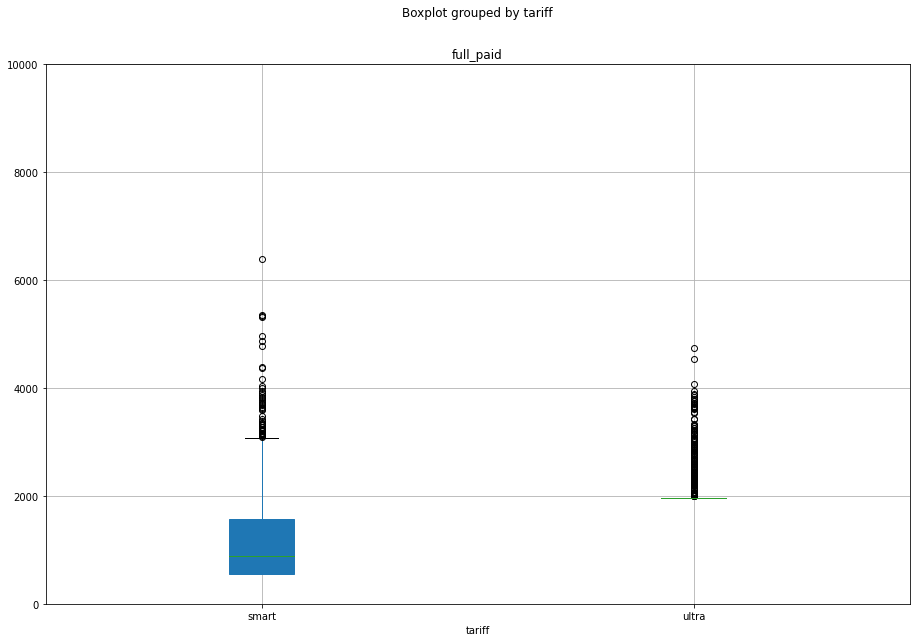

In [31]:
df.boxplot(
    'full_paid',
    by='tariff',
    figsize=(15,10),
    patch_artist = True,
).set_ylim(-1,10000)

**- Заметим, что абоненты с тарифом `Ultra` в основной массе платят строго тарифный план, а абоненты `Smart` более склоны к переплате своего тарифа.**

<AxesSubplot:xlabel='full_paid', ylabel='Count'>

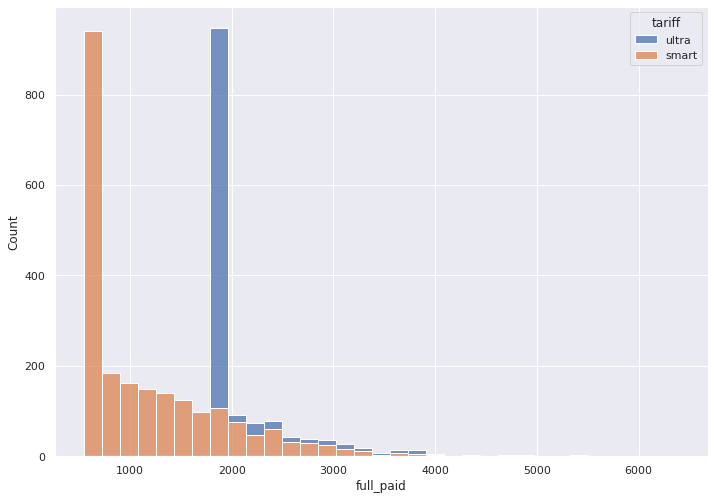

In [32]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.histplot(data=df, x="full_paid", hue="tariff", multiple="stack")

**- В эпоху мессенджеров пользователи обоих тарифов практически не используют сообщения.**

<AxesSubplot:xlabel='messages_count', ylabel='Count'>

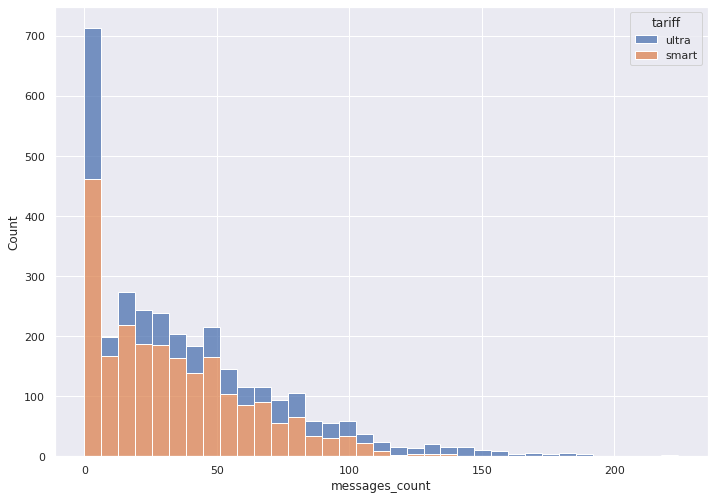

In [33]:
sns.histplot(data=df, x="messages_count", hue="tariff", multiple="stack")

**- С учетом лимита в 15гб и 30гб заметно, что в большей степени люди склоны доплачивать за дополнительные гигабайты.**

<AxesSubplot:xlabel='mb_used', ylabel='Count'>

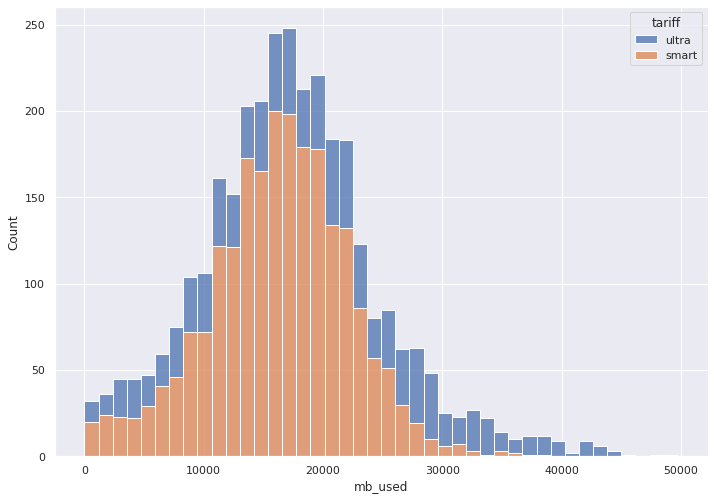

In [34]:
sns.histplot(data=df, x="mb_used", hue="tariff", multiple="stack")

**- В общей массе пользователи `Smart` используют все свои 500 минут и иногда перерасходуют данный показатель, в то время как пользователи тарифа `Ultra`  с 3000 минутами не доходят до половины максимально возможного показателя.**

<AxesSubplot:xlabel='calls_duration', ylabel='Count'>

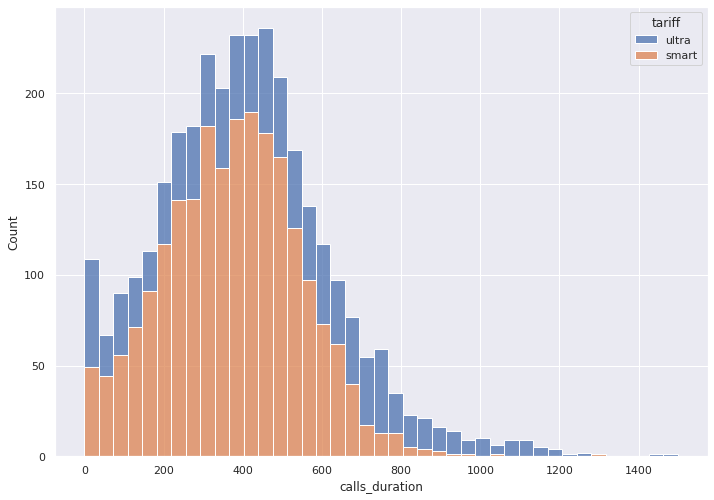

In [35]:
sns.histplot(data=df, x="calls_duration", hue="tariff", multiple="stack")

## **Проверка гипотезы**

- H0 средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;

- H1 средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

- alpha = .05

**- Cредняя выручка пользователей тарифa «Смарт» не равна средней выручке пользвателей тарифа «Ультра»**

In [36]:
# примем пороговое значение alpha:
alpha = .05

smart = df.query('tariff == "smart"')
smart = smart['full_paid']
ultra = df.query('tariff == "ultra"')
ultra = ultra['full_paid']  

results = st.ttest_ind(
    smart, 
    ultra)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.1428411753052693e-228
Отвергаем нулевую гипотезу


In [39]:
smart.head()

977    1149
978     550
979     550
980     983
981    1518
Name: full_paid, dtype: int64

- P-уровень значимости слишком велик.

- Средняя выручка тарифа `Ultra` и `Smart` слишком сильно отличаются друг от друга.

- **Cредняя выручка пользователей из Москвы равна выручки пользователей из других регионов**

In [38]:

alpha = .05

msk = df.query('city == "Москва"')
msk = msk['full_paid']

nomsk = df.query('city != "Москва"')
nomsk = nomsk['full_paid']  

results = st.ttest_ind(
    msk, 
    nomsk)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.35748892234162066
Не получилось отвергнуть нулевую гипотезу


- P-уровень значимости равен 35%

- средняя выручка по Москве статистически отличается от других регионов.

## Общий вывод

По данным которые у меня были, узнали что больше всего дохода приносит тариф "Смарт", у него больше всего абонентов во-первых, во-вторых доход в среднем превышает в 2 раза больше абонентскую оплату, из за нехватки интернет-трафика, смс, и минут для разговора абоненты оплачивают сверх абонентской оплаты.

- Поведение пользователей тарифов Smart & Ultra очень разные.


- SMS никто из 2х тарифов практически не пользуется.


- Пользователи Smart свойственно переплачивать за Звонки & Интернет.


- Пользователи Ultra в большей степени не израсходывают свои лимиты.


- Выручка регионов статистически не отличается от выручки в Москве, все пользователи в среднем тратят одинаково, но с вероятностью в 35 процентов выручка в Москве и регионах может отличаться.



- Хочется заметить, что тариф Smart приносит намного больше прибыли из-за переплаты по условиям тарифа, также таких пользователей в 2 раза больше пользователей Ultra.

- Пользователей тарифа Ultra меньше, т.к. не все способны оплачивать 1950 рублей в месяц, и думая, что 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика слишком много дня них. 
- Компании "Мегайлайн" следует внедрить новый тариф/переработать Smart с более высокой абонентской платы, нежели в тарифе Smart и с более улучшенными условиями по интернет-трафику и звонкам.